In [65]:
%matplotlib inline
import config_keys
import twitter
import re 
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
                                           

twitter_api = twitter.Api(
    consumer_key         =   twitter_keys['consumer_key'],
    consumer_secret      =   twitter_keys['consumer_secret'],
    access_token_key     =   twitter_keys['access_token_key'],
    access_token_secret  =   twitter_keys['access_token_secret'],
    tweet_mode = 'extended'
)


In [2]:
#TweetMiner function from Mike Roman

class TweetMiner(object):

    def __init__(self, api, result_limit = 20):
        
        self.api = api        
        self.result_limit = result_limit
        
    def mine_user_tweets(self, user="HillaryClinton", mine_retweets=False, max_pages=20):

        data           =  []
        last_tweet_id  =  False
        page           =  1
        
        while page <= max_pages:
            
            if last_tweet_id:
                statuses   =   self.api.GetUserTimeline(screen_name=user, count=self.result_limit, max_id=last_tweet_id - 1, include_rts=mine_retweets)
                statuses = [ _.AsDict() for _ in statuses]
            else:
                statuses   =   self.api.GetUserTimeline(screen_name=user, count=self.result_limit, include_rts=mine_retweets)
                statuses = [_.AsDict() for _ in statuses]
                
            for item in statuses:
                # Using try except here.
                # When retweets = 0 we get an error (GetUserTimeline fails to create a key, 'retweet_count')
                try:
                    mined = {
                        'tweet_id':        item['id'],
                        'handle':          item['user']['screen_name'],
                        'retweet_count':   item['retweet_count'],
                        'text':            item['full_text'],
                        'mined_at':        datetime.datetime.now(),
                        'created_at':      item['created_at'],
                    }
                
                except:
                        mined = {
                        'tweet_id':        item['id'],
                        'handle':          item['user']['screen_name'],
                        'retweet_count':   0,
                        'text':            item['full_text'],
                        'mined_at':        datetime.datetime.now(),
                        'created_at':      item['created_at'],
                    }
                
                last_tweet_id = item['id']
                data.append(mined)
                
            page += 1
            
        return data

In [3]:
miner = TweetMiner(twitter_api, result_limit=200)

In [5]:
#embiid = miner.mine_user_tweets(user="JoelEmbiid")
james = miner.mine_user_tweets(user="KingJames")
#mccollum = miner.mine_user_tweets(user="CJMcCollum")
#durant = miner.mine_user_tweets(user="KDTrey5")
#lillard = miner.mine_user_tweets(user="Dame_Lillard")
woj = miner.mine_user_tweets(user="wojespn")
#shams = miner.mine_user_tweets(user="shamscharania")

In [87]:
#embiid_df = pd.DataFrame(embiid)
james_df = pd.DataFrame(james)
#mccollum_df= pd.DataFrame(mccollum)
#durant_df = pd.DataFrame(durant)
#lillard_df = pd.DataFrame(lillard)
woj_df= pd.DataFrame(woj)
#shams_df = pd.DataFrame(shams)

#tweets = pd.concat([embiid_df, james_df, mccollum_df,durant_df,lillard_df], axis=0)

#tweets = pd.concat([embiid_df,lillard_df, james_df], axis=0)
tweets = pd.concat([woj_df,james_df], axis=0)

def remove_non_ascii(text):
    return ''.join(i for i in text if ord(i)<128)

james_df['text'] = james_df['text'].apply(remove_non_ascii)
james_df['created_at'] = pd.to_datetime(james_df['created_at'])
james_df['created_at'] = james_df['created_at'].dt.date

d = datetime.datetime.strptime('2018-10-01', '%Y-%m-%d').date()
james_df = james_df[(james_df.created_at > d)]




#embiid_df.head()
#james_df.dtypes
james_df.tail()


,created_at,handle,mined_at,retweet_count,text,tweet_id
245,2018-10-05,KingJames,2019-04-09 16:06:27.209665,15801,Lil bro gone be a problem!! #YoungDripKing @B_...,1048090260318515200
246,2018-10-04,KingJames,2019-04-09 16:06:27.209668,20028,Flat out MONSTER!!! #DRoseForever Happy Gday h...,1047871418820485121
247,2018-10-03,KingJames,2019-04-09 16:06:27.209672,2970,to @jtimberlake @JessicaBiel!! Thank you so m...,1047598107431587840
248,2018-10-03,KingJames,2019-04-09 16:06:27.209675,1595,Way to work my brother!!! @RomeTrav #MidRangeR...,1047494057373589505
249,2018-10-02,KingJames,2019-04-09 16:06:27.209679,4224,TONIGHT #StudentAthleteHBO https://t.co/aaKwp...,1047265875428954112


(array([736968., 736999., 737029., 737060., 737091., 737119., 737150.]),
 <a list of 7 Text xticklabel objects>)

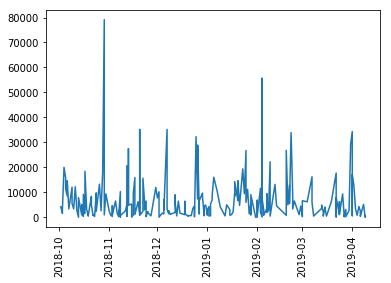

In [88]:
plt.plot(james_df['created_at'], james_df['retweet_count'])
plt.xticks(rotation='vertical')

In [89]:
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
nba_teams = teams.get_teams()
lakers = [team for team in nba_teams if team['abbreviation'] == 'LAL'][0]
lakers_id = lakers['id']

gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=lakers_id)
games = gamefinder.get_data_frames()[0]
games.groupby(games.SEASON_ID.str[-4:])[['GAME_ID']].count().loc['2018':]

games_to_keep = games[(games.SEASON_ID.str[-4:] == '2018') ]
games_to_keep = games_to_keep.reset_index(drop=True)
games_to_keep.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22018,1610612747,LAL,Los Angeles Lakers,0021801208,2019-04-07,LAL vs. UTA,W,240,113,...,0.667,16.0,33.0,49.0,28,5.0,5.0,16.0,21,4.0
1,22018,1610612747,LAL,Los Angeles Lakers,0021801192,2019-04-05,LAL @ LAC,W,240,122,...,0.815,14.0,41.0,55.0,28,8.0,10.0,14.0,24,5.0
2,22018,1610612747,LAL,Los Angeles Lakers,0021801179,2019-04-04,LAL vs. GSW,L,240,90,...,0.571,18.0,44.0,62.0,25,10.0,7.0,18.0,10,-18.0
3,22018,1610612747,LAL,Los Angeles Lakers,0021801161,2019-04-02,LAL @ OKC,L,240,103,...,0.700,4.0,35.0,39.0,26,7.0,2.0,21.0,25,-16.0
4,22018,1610612747,LAL,Los Angeles Lakers,0021801147,2019-03-31,LAL @ NOP,W,240,130,...,0.864,11.0,35.0,46.0,30,16.0,5.0,10.0,20,28.0


In [90]:
game_dates = games_to_keep['GAME_DATE'].tolist()
WL = games_to_keep['WL'].tolist()

#print game_dates
#print WL 

james_df['game_today'] = 0
james_df['win'] = -1


num = len(james_df.index)
for index, row in james_df.iterrows():
    current_game = james_df['created_at'].iloc[index]
    if (str(current_game) in game_dates):
        james_df['game_today'].iloc[index] = 1 

        
#james_df.tail()
#print(james_df.to_string())


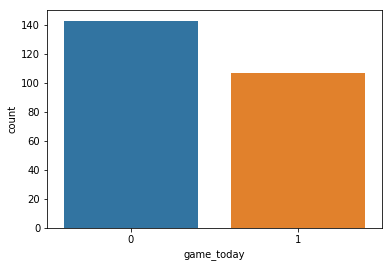

In [95]:

cn = sns.countplot(x="game_today", data=james_df)


In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import matplotlib.pyplot as plt

vect = TfidfVectorizer(ngram_range=(2,4), stop_words='english')

summaries = "".join(james_df['text'])
ngrams_summaries = vect.build_analyzer()(summaries)

ng, c = zip(*Counter(ngrams_summaries).most_common(20))
freq = pd.DataFrame(
    {'ngram': ng,
     'values': c,
    })

freq.head()


,ngram,values
0,striveforgreatness https,93
1,striveforgreatness http,67
2,lil bro,34
3,good luck,24
4,yes sir,23


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

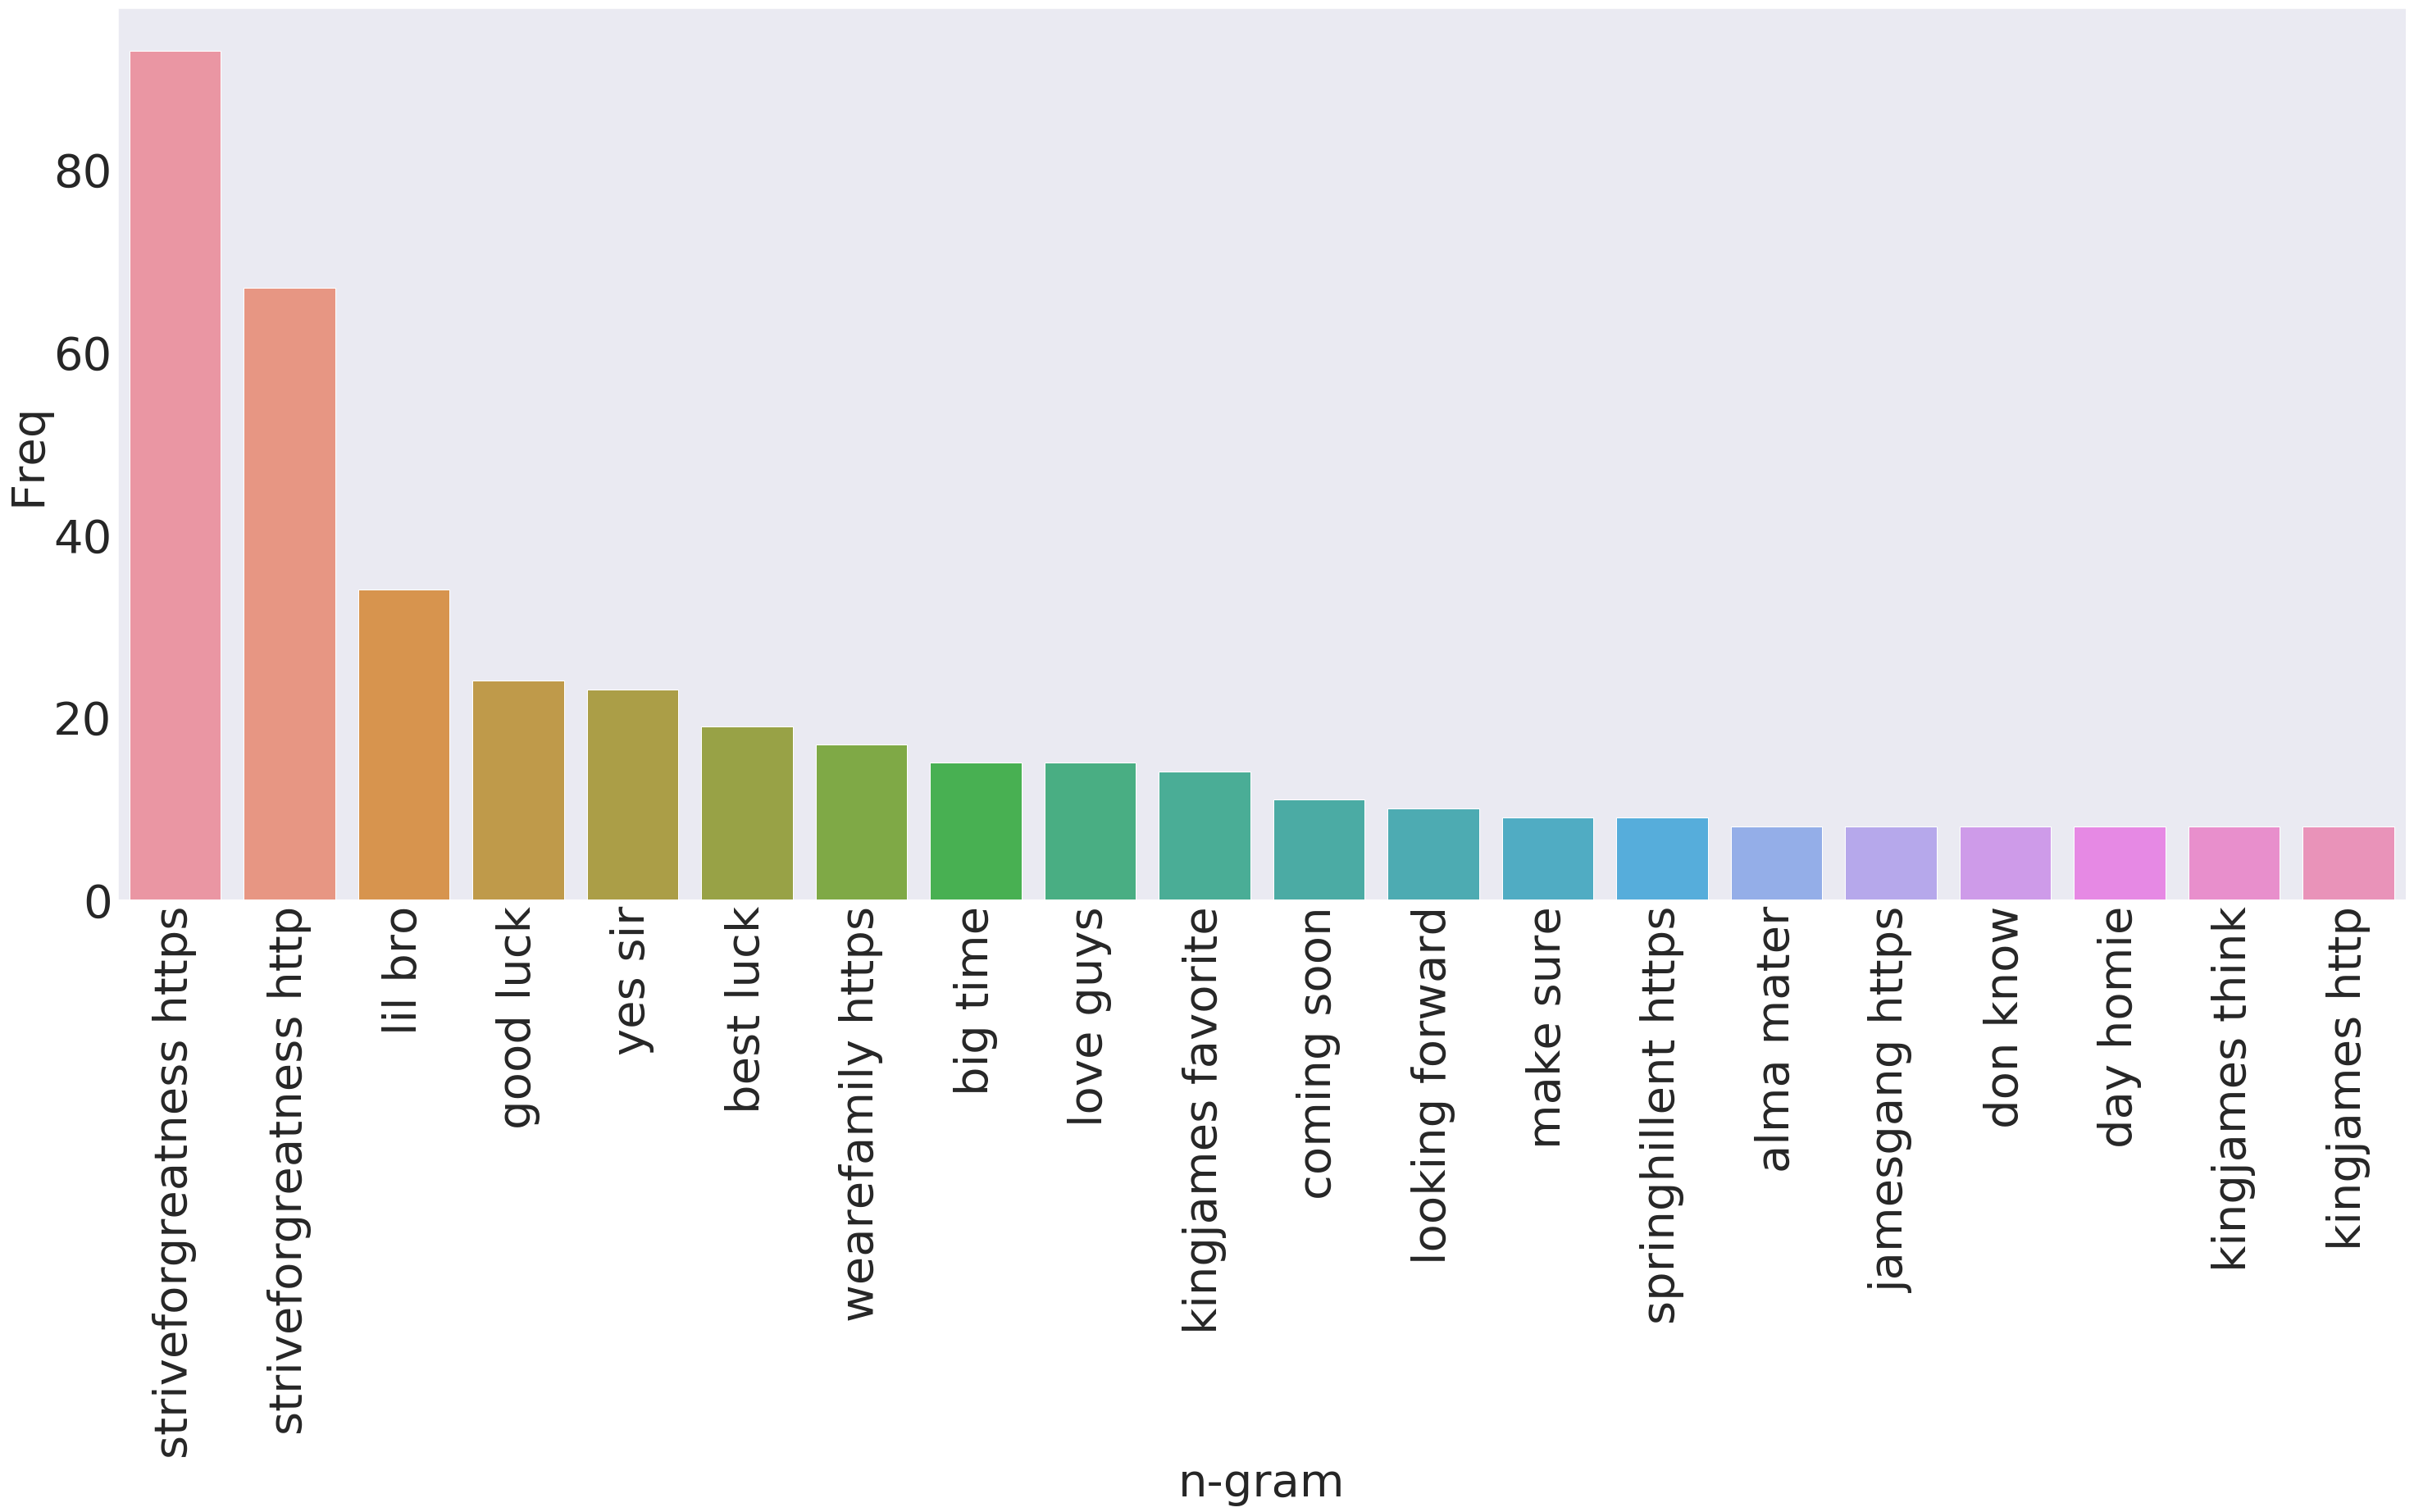

In [94]:
import seaborn as sns 
sns.set_style("dark")
sns.set_color_codes()
plt.figure(figsize=(50,20))
count = sns.barplot(x="ngram", y="values", data=freq)


count.set_ylabel("Freq")
count.set_xlabel("n-gram")
#
for item in ([count.xaxis.label, count.yaxis.label] +
             count.get_xticklabels() + count.get_yticklabels()):
    item.set_fontsize(56)
plt.xticks(rotation=90)


In [69]:
from textacy.preprocess import preprocess_text

tweet_text = tweets['text'].values
clean_text = [preprocess_text(t, fix_unicode=True, lowercase=True, 
                              no_urls=True, no_emails=True, no_phone_numbers=True,
                              no_currency_symbols=True, no_punct=True, no_accents=True)
              for t in tweet_text]

print tweet_text[1:8]
print '-------------------------------------------------------------------------------------'
print clean_text[1:8]


[u'New Orleans interim GM Danny Ferry is meeting with franchise officials today about the permanent GM job, league sources tell ESPN. Ferry is the final interview among several candidates, including David Griffin, Larry Harris, Trajan Langdon, Gersson Rosas and Tommy Sheppard.'
 u'@DanWetzel Mostly glad our friendship has withstood several years of Bonnies dominance over UMass.'
 u'Even sweeter for Steve Clifford to clinch Orlando\u2019s return to the playoffs in Boston tonight. He\u2019s a Maine kid who once worked down the street at BU for Brett Brown\u2019s dad, Bob. Few league coaches maximized their roster the way Clifford did this season.'
 u'Strained oblique for Boston\u2019s Marcus Smart, league source tells ESPN. They\u2019ll see how it responds in next 24-48 hours.'
 u'The Nets return to the playoffs, traveling a hard road. https://t.co/iN6S7IiSg1'
 u'@CalCoachG @MariaTaylor Two ballers right there (three counting mom)'
 u'The Clippers waiving of Luc Mbah A Moute -- who was l

In [16]:
y = tweets['handle'].map(lambda x: 1 if x == 'wojespn' else 0).values
print max(pd.Series(y).value_counts(normalize=True))

0.527838033261


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.svm import SVC


#Vectorizing with TF-IDF Vectorizer and creating X matrix
tfv = TfidfVectorizer(ngram_range=(2,4), max_features=2000)
X = tfv.fit_transform(clean_text).todense()
print X.shape

(5532, 2000)


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
LogisticRegression(solver='lbfgs')

params = {'penalty': ['l1', 'l2'], 'C':np.logspace(-5,0,100)}
#Grid searching to find optimal parameters for Logistic Regression
gs = GridSearchCV(lr, param_grid=params, cv=10, verbose=1)
gs.fit(X, y)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kmistry/.local/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  2.8min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([1.00000e-05, 1.12332e-05, ..., 8.90215e-01, 1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [19]:
print gs.best_params_
print gs.best_score_

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(LogisticRegression(), X, y, cv=10)

print accuracies.mean()
print 1-y.mean()

{'penalty': 'l2', 'C': 1.0}
0.9128705712219812
0.9128726800321187
0.5278380332610267


In [20]:
estimator = LogisticRegression(penalty='l2',C=1.0)
estimator.fit(X,y)

# Prep our source as TfIdf vectors
source_test = [
    "That’s was AMAZING!!! Got me so hyped I wanted to be in it too! Kudos", #Lebron James Tweet 
    "ESPN story on Tim Connelly’s contract extension with the revitalized Denver Nuggets." # Woj tweet
]
Xtest = tfv.transform(source_test)
pd.DataFrame(estimator.predict_proba(Xtest), columns=["Proba_durant", "Proba_woj"])

,Proba_durant,Proba_woj
0,0.725875,0.274125
1,0.038192,0.961808
